## SEIM - Projeto prático de processamento de imagem 2024/2025
Gabriel Pinto (pg55943) e Bruno Martins (pg56211)


### - Montagem do suporte para obtenção de imagens

{{{blah blah blah, foto do setup mítico que certamente vamos ter}}}


### - Parte 1: Contagem de retângulos separados e paralelos aos eixos

  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl (39.5 MB)
Note: you may need to restart the kernel to use updated packages.
Hough detected lines but no clear orthogonal pairs—falling back to contour method.
Calibration via contour: 0.9615 mm/pixel


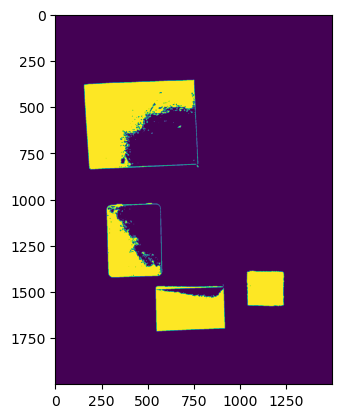

Detected 1 rectangles:
Center: (1091.826923076923, 1427.4038461538462), W: 189.4 mm, H: 174.0 mm, Area: 32966.9 mm^2


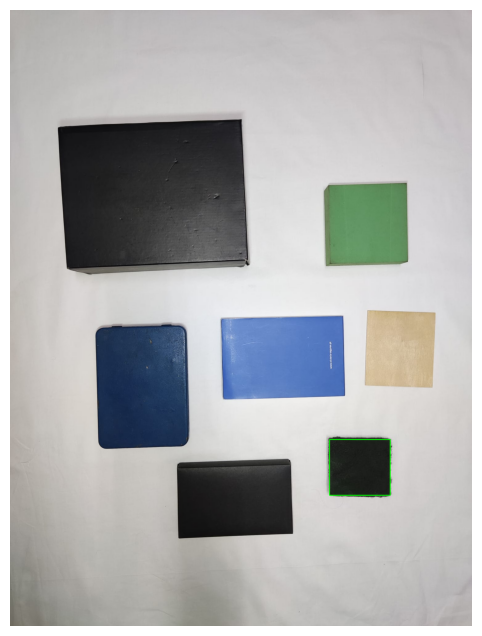

In [4]:
%pip install opencv-python

import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- Paths ---
CALIB_IMG_PATH = "./imgs/img_cal.jpeg"
TEST_IMG_PATH = "./imgs/img_2.10.jpeg"

# --- Parâmetros de Hough  ---
HOUGH_THRESH = 30       # threshold para os votos da função HoughLinesP
MIN_LINE_LENGTH = 30    # comprimento mínimo (em píxeis)
MAX_LINE_GAP = 10       # gap max que pode haver entre segmentos de retas


# --- Calibração para obtenção da relação "quantos milímetros por píxel" ---
def calibrate(image_path, square_size_mm=50.0):
    """
    A função presente tenta calibrar a relação de milímetros por cada píxel usando um retângulo de dimensões conhecidas.
    Tenta usar HoughLinesP para encontrar as linhas; caso falhe, utiliza um plano B com a função cv2.findContours
    """
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)

    # Try Hough-based line detection
    lines = cv2.HoughLinesP(edges, 1, np.pi/180,
                            threshold=HOUGH_THRESH,
                            minLineLength=MIN_LINE_LENGTH,
                            maxLineGap=MAX_LINE_GAP)
    if lines is not None:
        # Separate horizontal/vertical lengths
        horiz, vert = [], []
        for x1,y1,x2,y2 in lines.reshape(-1,4):
            if abs(y1-y2) < 5:
                horiz.append(abs(x2 - x1))
            elif abs(x1-x2) < 5:
                vert.append(abs(y2 - y1))
        if horiz and vert:
            avg_w = np.mean(horiz)
            avg_h = np.mean(vert)
            mm_per_pixel = square_size_mm / max(avg_w, avg_h)
            print(f"Calibration via Hough: {mm_per_pixel:.4f} mm/pixel")
            return mm_per_pixel
        else:
            print("Hough detected lines but no clear orthogonal pairs—falling back to contour method.")
    else:
        print("No lines from Hough—falling back to contour method.")

    # --- Fallback: contour-based calibration ---
    # Threshold to binary and find contours
    blurred = cv2.GaussianBlur(gray, (5,5), 0)
    _, thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Find largest 4-point contour (assumed calibration square)
    best = None
    max_area = 0
    for cnt in contours:
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
        if len(approx) == 4:
            x,y,w,h = cv2.boundingRect(approx)
            area = w*h
            if area > max_area:
                max_area = area
                best = (w, h)
    if best is None:
        raise ValueError("Calibration failed: no square contour found")

    w, h = best
    mm_per_pixel = square_size_mm / max(w, h)
    print(f"Calibration via contour: {mm_per_pixel:.4f} mm/pixel")
    return mm_per_pixel

# --- Rectangle detection via contours ---
def detect_objects(image_path, mm_per_pixel, min_area_mm2=1000):
    img = cv2.imread(image_path)
    orig = img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5,5), 0)
    _, thresh = cv2.threshold(blurred, 47, 255, cv2.THRESH_BINARY_INV)
    plt.imshow(thresh)
    plt.show()
    
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    rectangles = []
    for cnt in contours:
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
        if len(approx) == 4 and cv2.isContourConvex(approx):
            x,y,w,h = cv2.boundingRect(approx)
            area_mm2 = (w * h) * (mm_per_pixel ** 2)
            if area_mm2 < min_area_mm2:
                continue
            width_mm = w * mm_per_pixel
            height_mm = h * mm_per_pixel
            center_mm = ((x + w/2) * mm_per_pixel, (y + h/2) * mm_per_pixel)
            perimeter_mm = 2 * (width_mm + height_mm)
            rectangles.append({
                'pixel_coords': {'top_left': (x, y), 'bottom_right': (x+w, y+h)},
                'center_mm': center_mm,
                'width_mm': width_mm,
                'height_mm': height_mm,
                'perimeter_mm': perimeter_mm,
                'area_mm2': area_mm2
            })
    return orig, rectangles

# --- Drawing ---
def draw_rectangles(img, rectangles):
    for rect in rectangles:
        tl = rect['pixel_coords']['top_left']
        br = rect['pixel_coords']['bottom_right']
        cv2.rectangle(img, tl, br, (0,255,0), 2)
    plt.figure(figsize=(8,8))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    mm_per_px = calibrate(CALIB_IMG_PATH)
    img, rects = detect_objects(TEST_IMG_PATH, mm_per_px)
    print(f"Detected {len(rects)} rectangles:")
    for r in rects:
        print(f"Center: {r['center_mm']}, W: {r['width_mm']:.1f} mm, H: {r['height_mm']:.1f} mm, Area: {r['area_mm2']:.1f} mm^2")
    draw_rectangles(img, rects)


Com este código, a calibração foi um sucesso, apesar de não identificar todos os retângulos nas imagens de teste. Na média das 6 imagens testadas, a performance do código demonstrou que acertou 73.8% (std= ) dos retângulos, tendo ainda rejeitado corretamente todas as formas não retangulares presentes.